In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle


In [2]:
data_frame = pd.read_json('train.json',lines = True)
print("Total Number of Samples:",data_frame.shape[0])
data_frame.head()

Total Number of Samples: 281480


,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful
0,68842,271479,What are the job opportunities after MBBS ?,71897,What are the job opportunities after a M.Tech ?,2998,you can apply as Assistant professor or work a...,0,1,0
1,296523,427213,How good is IIM Shillong for Finance ?,427214,How good is IIM Shillong ?,33663,What I have heard from people in the academic ...,0,1,0
2,341084,480292,Catchy dance slogans ?,480293,Which s the best book for IBPS it offcer ?,17062,best book you should study for an IBPS IT Offi...,0,1,0
3,348383,383938,Why does Quora show the number of downvotes on...,132794,Why doesn't Quora show the number of downvotes...,107765,Because there is no reason for them to do so.,0,1,0
4,98550,198647,Is Lamborghini better than Ferrari ?,198648,Why is Lamborghini better than Ferrari ?,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1


In [3]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281480 entries, 0 to 281479
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   guid           281480 non-null  int64 
 1   qu_id          281480 non-null  int64 
 2   qu             281480 non-null  object
 3   qa_id          281480 non-null  int64 
 4   qa             281480 non-null  object
 5   ans_id         281480 non-null  int64 
 6   ans            281480 non-null  object
 7   is_duplicate   281480 non-null  int64 
 8   is_correspond  281480 non-null  int64 
 9   is_useful      281480 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 21.5+ MB


# Analysis of the full training dataset

In [4]:
data_frame = data_frame[data_frame.is_correspond !=0] #remove rows where is_correspond equal to zero(is_correspond	whether `ans' is the answer of `qa')
QApair_df = data_frame.copy() #copying data to another dataframe
QApair_df.head()

,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful
0,68842,271479,What are the job opportunities after MBBS ?,71897,What are the job opportunities after a M.Tech ?,2998,you can apply as Assistant professor or work a...,0,1,0
1,296523,427213,How good is IIM Shillong for Finance ?,427214,How good is IIM Shillong ?,33663,What I have heard from people in the academic ...,0,1,0
2,341084,480292,Catchy dance slogans ?,480293,Which s the best book for IBPS it offcer ?,17062,best book you should study for an IBPS IT Offi...,0,1,0
3,348383,383938,Why does Quora show the number of downvotes on...,132794,Why doesn't Quora show the number of downvotes...,107765,Because there is no reason for them to do so.,0,1,0
4,98550,198647,Is Lamborghini better than Ferrari ?,198648,Why is Lamborghini better than Ferrari ?,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1


# Distribution of samples among output labels

<AxesSubplot:xlabel='is_duplicate'>

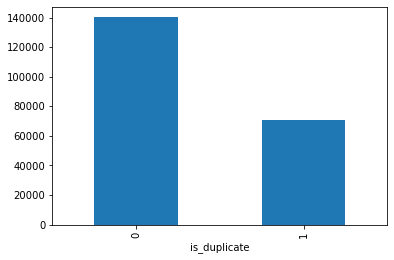

In [5]:
QApair_df.groupby("is_duplicate")['guid'].count().plot.bar()

In [6]:
print("Total Number of samples:",len(QApair_df))
print("Percent of Question pairs which are duplicates/similar: %.2f"% (QApair_df["is_duplicate"].mean()*100)+'%')
print("Percent of Question pairs which are non-duplicates/non-similar: %.2f"% ((1-QApair_df["is_duplicate"].mean())*100)+'%')

Total Number of samples: 210803
Percent of Question pairs which are duplicates/similar: 33.54%
Percent of Question pairs which are non-duplicates/non-similar: 66.46%


# Stats on Question used in the dataset

In [7]:
qu_ids = pd.Series(list(QApair_df['qu_id']))
unique_uqs = len(np.unique(qu_ids)) #num of unique user questions
uqs_repeated = np.sum(qu_ids.value_counts()>1) #getting num of user question appeared more than one time
print("Number of Unique User Questions :", unique_uqs)
print("Unique User Questions appeared more than one time : ", uqs_repeated,"\n\n")
    
qa_ids = pd.Series(list(QApair_df['qa_id']))
unique_aqs =  len(np.unique(qa_ids)) # num of unique archived questions
aqs_repeated = np.sum(qa_ids.value_counts()>1) #getting num of archived question appeared more than one time
print("Number of Unique Archived Questions :", unique_aqs)
print("Unique Archived Questions appeared more than one time : ", aqs_repeated)



Number of Unique User Questions : 172368
Unique User Questions appeared more than one time :  22586 


Number of Unique Archived Questions : 155759
Unique Archived Questions appeared more than one time :  28894


In [8]:
#finding if there is any duplicate rows

duplicate_rows= QApair_df[['qu_id','qa_id','is_duplicate']].groupby(['qu_id','qa_id']).count().reset_index()

print ("Duplicate pair of rows:",(duplicate_rows).shape[0] - QApair_df.shape[0])

Duplicate pair of rows: -29


# Analysis on number of times each question repeated in the dataset

C:\Users\ASUS\Anaconda3\envs\venv_nlp\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


Maximum number of times a question is repeated: 50



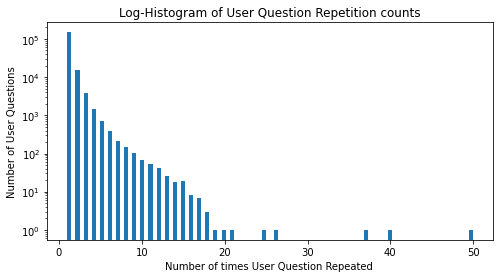

In [9]:
plt.figure(figsize=(8, 4))

plt.hist(qu_ids.value_counts(), bins=100)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of User Question Repetition counts')

plt.xlabel('Number of times User Question Repeated ')

plt.ylabel('Number of User Questions')

print ('Maximum number of times a question is repeated: {}\n'.format(max(qu_ids.value_counts())))

C:\Users\ASUS\Anaconda3\envs\venv_nlp\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


Maximum number of times a question is repeated: 61



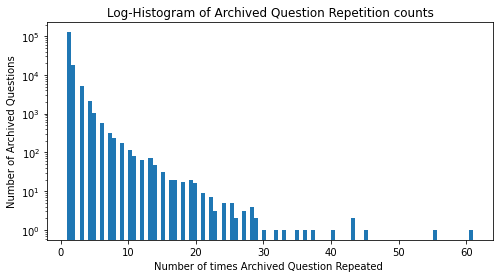

In [10]:
plt.figure(figsize=(8, 4))

plt.hist(qa_ids.value_counts(), bins=100)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of Archived Question Repetition counts')

plt.xlabel('Number of times Archived Question Repeated ')

plt.ylabel('Number of Archived Questions')

print ('Maximum number of times a question is repeated: {}\n'.format(max(qa_ids.value_counts())))

# Checking for null values

In [11]:
nan_rows = QApair_df[QApair_df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [guid, qu_id, qu, qa_id, qa, ans_id, ans, is_duplicate, is_correspond, is_useful]
Index: []


There are no rows with null values

# Feature Engineering

In [12]:
QApair_df['f_uq'] = QApair_df.groupby('qu_id')['qu_id'].transform('count')
QApair_df['f_aq'] = QApair_df.groupby('qa_id')['qa_id'].transform('count')
QApair_df['l_uq'] = QApair_df['qu'].str.len()
QApair_df['l_aq'] = QApair_df['qa'].str.len()
QApair_df['num_words_uq'] = QApair_df['qu'].apply(lambda x: len(x.split(" ")))
QApair_df['num_words_aq'] = QApair_df['qa'].apply(lambda x: len(x.split(" ")))

# 
def find_word_Common(sample):
    """finding number of words common in both user question and archived Question"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" ")))    
    return len(uq & aq)*1.0
QApair_df['n_common_words'] = QApair_df.apply(find_word_Common, axis=1)

def find_total_word_count(sample):
    """Finding total number of words in both user and archived questions"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" ")))   
    return (len(uq) + len(aq))*1.0
QApair_df['total_word_count'] = QApair_df.apply(find_total_word_count, axis=1)

def fraction_common_words(sample):
    """Finding the ratio of the number of words in common and total number of words in user and archived questions"""
    uq = set(map(lambda w: w.lower().strip(), sample['qu'].split(" ")))
    aq = set(map(lambda w: w.lower().strip(), sample['qa'].split(" "))) 
    return 1.0 * len(uq & aq)/(len(uq) + len(aq))
QApair_df['fraction_common_words'] = QApair_df.apply(fraction_common_words, axis=1)




In [13]:
QApair_df.head()

,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
0,68842,271479,What are the job opportunities after MBBS ?,71897,What are the job opportunities after a M.Tech ?,2998,you can apply as Assistant professor or work a...,0,1,0,1,1,43,47,8,9,7.0,17.0,0.411765
1,296523,427213,How good is IIM Shillong for Finance ?,427214,How good is IIM Shillong ?,33663,What I have heard from people in the academic ...,0,1,0,1,1,38,26,8,6,6.0,14.0,0.428571
2,341084,480292,Catchy dance slogans ?,480293,Which s the best book for IBPS it offcer ?,17062,best book you should study for an IBPS IT Offi...,0,1,0,1,1,22,42,4,10,1.0,14.0,0.071429
3,348383,383938,Why does Quora show the number of downvotes on...,132794,Why doesn't Quora show the number of downvotes...,107765,Because there is no reason for them to do so.,0,1,0,2,2,58,86,12,17,9.0,25.0,0.360000
4,98550,198647,Is Lamborghini better than Ferrari ?,198648,Why is Lamborghini better than Ferrari ?,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538


# Analysis of extracted features:

In [14]:
print("Maximum length of user questions: ", max(QApair_df['num_words_uq']))
print("Minimum length of user questions: ", min(QApair_df['num_words_uq']),'\n')


print("Maximum length of archived questions: ", max(QApair_df['num_words_aq']))
print("Minimum length of archived questions: ", min(QApair_df['num_words_aq']),'\n')

print("Number of user questions with minimum length:", QApair_df[QApair_df['num_words_uq']== min(QApair_df['num_words_uq'])].shape[0])

print("Number of archived questions with minimum length:", QApair_df[QApair_df['num_words_aq']== min(QApair_df['num_words_aq'])].shape[0])


Maximum length of user questions:  261
Minimum length of user questions:  1 

Maximum length of archived questions:  130
Minimum length of archived questions:  1 

Number of user questions with minimum length: 25
Number of archived questions with minimum length: 7


# Statistics for Data cleaning

In [15]:

print("Average user question length: ", np.mean(QApair_df['l_uq']))
print("Average archived question length: ", np.mean(QApair_df['l_aq']))

print("\nAverage user question word count: ", np.mean(QApair_df['num_words_uq']))
print("Average archived question word count: ", np.mean(QApair_df['num_words_aq']))

print("\nNumber of user question with length <= 5: ", len(QApair_df[QApair_df['l_uq']<=5]))
print("Number of archived question with length <= 5: ", len(QApair_df[QApair_df['l_aq']<=5]))


Average user question length:  60.851686171449174
Average archived question length:  59.89521496373391

Average user question word count:  12.412916324720236
Average archived question word count:  12.29035639910248

Number of user question with length <= 5:  26
Number of archived question with length <= 5:  8


In [16]:
#as part of data cleaning we are droping rows with length of question less than 5.
QApair_df = QApair_df[QApair_df['l_uq']>5] #dropping user questions with length<=5
QApair_df = QApair_df[QApair_df['l_aq']>5] #dropping archived questions with length <=5


# Selecting training data

In [17]:
# from the analysis we are going to choose first 6k samples of the dataset as our training dataset
#balanced classes
duplicate_df = QApair_df
duplicate_df = duplicate_df[data_frame.is_duplicate !=0] #seleting only duplicate questions
duplicate_df = duplicate_df[0:4000]
print(duplicate_df.shape)
nonduplicate_df = QApair_df
nonduplicate_df = nonduplicate_df[data_frame.is_duplicate !=1] #selecting non duplicate questions
nonduplicate_df = nonduplicate_df[0:4000]
print(nonduplicate_df.shape)

train_df = duplicate_df.append(nonduplicate_df)
print(train_df.shape)
train_df.head()




(4000, 19)
(4000, 19)
(8000, 19)


C:\Users\ASUS\Anaconda3\envs\venv_nlp\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\ASUS\Anaconda3\envs\venv_nlp\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
4,98550,198647,Is Lamborghini better than Ferrari ?,198648,Why is Lamborghini better than Ferrari ?,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538
8,23880,122782,What does a Trump presidency mean for Indian s...,12385,How would Trump presidency affect Indian stude...,76886,"In the last Presidential debate, the conservat...",1,1,1,2,17,97,61,17,11,6.0,28.0,0.214286
12,108664,210485,`` Why is North America considered'' `` the We...,210486,`` Is North America considered'' `` the west''...,98240,The British invented the Prime Meridian. They...,1,1,1,1,1,56,52,10,9,8.0,17.0,0.470588
13,106306,181906,"If you could live in a movie , what movie woul...",201042,If you could enter the reality inside a movie ...,74909,Midnight in Paris..!Fantasising about living i...,1,1,1,2,2,63,111,16,23,10.0,33.0,0.303030
15,103382,518790,What jobs are in art stream ?,518791,What are scopes of arts stream ?,129264,You can opt anything as your carrier other tha...,1,1,1,1,1,29,32,7,7,4.0,14.0,0.285714


<AxesSubplot:xlabel='is_duplicate'>

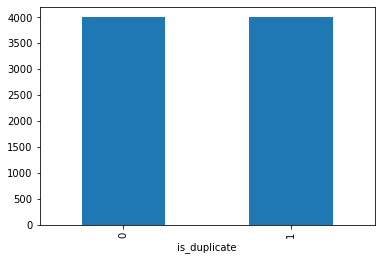

In [18]:

train_df.groupby("is_duplicate")['guid'].count().plot.bar()

In [19]:
print("Total Number of samples:",len(train_df))
print("Percent of Question pairs which are duplicates/similar: %.2f"% (train_df["is_duplicate"].mean()*100)+'%')
print("Percent of Question pairs which are non-duplicates/non-similar: %.2f"% ((1-train_df["is_duplicate"].mean())*100)+'%')

Total Number of samples: 8000
Percent of Question pairs which are duplicates/similar: 50.00%
Percent of Question pairs which are non-duplicates/non-similar: 50.00%


# Selecting test data

In [20]:
#test set selection
test_df = QApair_df
test_df = test_df[data_frame.is_duplicate !=0] #seleting only duplicate questions
test_df = test_df[:2000]
test_df.index = list(range(len(test_df)))
print(test_df.shape)
test_df.head()

(2000, 19)


C:\Users\ASUS\Anaconda3\envs\venv_nlp\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
0,98550,198647,Is Lamborghini better than Ferrari ?,198648,Why is Lamborghini better than Ferrari ?,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538
1,23880,122782,What does a Trump presidency mean for Indian s...,12385,How would Trump presidency affect Indian stude...,76886,"In the last Presidential debate, the conservat...",1,1,1,2,17,97,61,17,11,6.0,28.0,0.214286
2,108664,210485,`` Why is North America considered'' `` the We...,210486,`` Is North America considered'' `` the west''...,98240,The British invented the Prime Meridian. They...,1,1,1,1,1,56,52,10,9,8.0,17.0,0.470588
3,106306,181906,"If you could live in a movie , what movie woul...",201042,If you could enter the reality inside a movie ...,74909,Midnight in Paris..!Fantasising about living i...,1,1,1,2,2,63,111,16,23,10.0,33.0,0.303030
4,103382,518790,What jobs are in art stream ?,518791,What are scopes of arts stream ?,129264,You can opt anything as your carrier other tha...,1,1,1,1,1,29,32,7,7,4.0,14.0,0.285714


In [21]:
# checking if there is any duplicate question repeated in archived test questions
idx_list = []
arch_questions = test_df['qa'].tolist()
for idx,uq in enumerate(test_df['qu'].tolist()):
    if uq in arch_questions:
        idx_list.append(arch_questions.index(uq))
    else:
        pass

test_df = test_df.drop(idx_list) #dropping rows with user question repeats in  archived questions
print("Shape of test_df",test_df.shape)
test_df.head()

Shape of test_df (1973, 19)


,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
0,98550,198647,Is Lamborghini better than Ferrari ?,198648,Why is Lamborghini better than Ferrari ?,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538
1,23880,122782,What does a Trump presidency mean for Indian s...,12385,How would Trump presidency affect Indian stude...,76886,"In the last Presidential debate, the conservat...",1,1,1,2,17,97,61,17,11,6.0,28.0,0.214286
2,108664,210485,`` Why is North America considered'' `` the We...,210486,`` Is North America considered'' `` the west''...,98240,The British invented the Prime Meridian. They...,1,1,1,1,1,56,52,10,9,8.0,17.0,0.470588
3,106306,181906,"If you could live in a movie , what movie woul...",201042,If you could enter the reality inside a movie ...,74909,Midnight in Paris..!Fantasising about living i...,1,1,1,2,2,63,111,16,23,10.0,33.0,0.303030
4,103382,518790,What jobs are in art stream ?,518791,What are scopes of arts stream ?,129264,You can opt anything as your carrier other tha...,1,1,1,1,1,29,32,7,7,4.0,14.0,0.285714


# Pre-Processing

In [22]:
stop_words = stopwords.words('english')
stop_words_list = ['Is', 'that', 'such', 'through', 'during', 'but', 'while', 'so', 'this', 'both', 'If', 'While', 'because', 'a', 'is', 'or', 'about', 'these', 'Which', 'an', 'than', 'for', 'what', 'those', 'just', 'as', 'which', 'of', 'This', 'and', 'to', 'then', 'if', 'the', 'What']

In [23]:
def clean_text(sent, remove_stp_words = False, stemming = False,lemmatize = False):
    
    # Cleaning each senetences by word contraction technique, substituting names countries 
    sent = re.sub(r"[^A-Za-z0-9]", " ", sent) #remove single characters
    sent = re.sub(r"<.*?>", " ", sent)    #remove HTML tags
    sent = re.sub(r"\'re", " are ", sent) #applying word contractions
    sent = re.sub(r"\'d", " would ", sent)
    sent = re.sub(r"what's", "", sent)
    sent = re.sub(r"What's", "", sent)
    sent = re.sub(r"\'s", " ", sent)
    sent = re.sub(r"\'ve", " have ", sent)
    sent = re.sub(r" e g ", " eg ", sent)
    sent = re.sub(r"can't", "cannot ", sent)
    sent = re.sub(r"n't", " not ", sent)
    sent = re.sub(r"I'm", "I am", sent)
    sent = re.sub(r" m ", " am ", sent)
    sent = re.sub(r"\'re", " are ", sent)
    sent = re.sub(r"\'d", " would ", sent)
    sent = re.sub(r"\'ll", " will ", sent)
    sent = re.sub(r" e g ", " eg ", sent)
    sent = re.sub(r" b g ", " bg ", sent)
    sent = re.sub(r"\0s", "0", sent)
    sent = re.sub(r" 9 11 ", "911", sent) #replacing phone nums to same format
    sent = re.sub(r"e-mail", "email", sent)
    sent = re.sub(r"quikly", "quickly", sent)
    sent = re.sub(r" u s ", " America ", sent)
    sent = re.sub(r" uk ", " England ", sent) #making country name same format
    sent = re.sub(r" UK ", " England ", sent)
    sent = re.sub(r"intially", "initially", sent)
    sent = re.sub(r" dms ", "direct messages ", sent)  
    sent = re.sub(r"kms", " kilometers ", sent) #making measurements same format
    sent = re.sub(r"KMs", " kilometers ", sent)
    sent = re.sub(r" cs ", " computer science ", sent) 
    sent = re.sub(r" upvotes ", " up votes ", sent)
    sent = re.sub(r" iPhone ", " phone ", sent)
    sent = re.sub(r"demonitization", "demonetization", sent) 
    sent = re.sub(r"calender", "calendar", sent)
    sent = re.sub(r"ios", "operating system", sent)
    sent = re.sub(r" usa ", " America ", sent)
    sent = re.sub(r" USA ", " America ", sent)
    sent = re.sub(r"gps", "GPS", sent)
    sent = re.sub(r"gst", "GST", sent)
    sent = re.sub(r"programing", "programming", sent) #spell correction
    sent = re.sub(r"bestfriend", "best friend", sent)
    sent = re.sub(r"the US", "America", sent)
    sent = re.sub(r"banglore", "Banglore", sent) #spell correction
    sent = re.sub(r" J K ", " JK ", sent)
    
    # punctuation removal and joining senteces with space
    sent = ' '.join([ww.lower() for ww in sent.split() if ww not in punctuation])
    #remove stop words if remove_stp_words == True
    if remove_stp_words:
        #removing stop words
        sent = ' '.join([ww for ww in sent.split() if ww not in stop_words_list])
    #perform stemming if stemming == true
    
    if stemming:
        stemmer = PorterStemmer()
        sent = ' '.join([stemmer.stem(ww) for ww in sent.split()])
    if lemmatize:
        wordnet_lemmatizer = WordNetLemmatizer()
        sent = ' '.join([wordnet_lemmatizer.lemmatize(ww,pos='v') for ww in sent.split()])
    return sent   
        
    

In [24]:
train_df = train_df.dropna()# drop NaN before preprocessing
test_df = test_df.dropna()# drop NaN
#saving dataset withour preprocessing
train_df.to_csv('no_preprocess_train.csv')
test_df.to_csv('no_preprocess_test.csv')

In [25]:
train_user_quest = train_df['qu'].tolist()
train_arch_quest = train_df['qa'].tolist()
test_user_quest = test_df['qu'].tolist()
test_arch_quest = test_df['qa'].tolist()

In [26]:
#cleaning the train text
train_df['qu'] = [clean_text(text) for text in train_user_quest]
train_df['qa'] = [clean_text(text) for text in train_arch_quest]

test_df['qu'] = [clean_text(text) for text in test_user_quest]
test_df['qa'] = [clean_text(text) for text in test_arch_quest]

In [27]:
train_df.head()

,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
4,98550,198647,is lamborghini better than ferrari,198648,why is lamborghini better than ferrari,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538
8,23880,122782,what does a trump presidency mean for indian s...,12385,how would trump presidency affect indian stude...,76886,"In the last Presidential debate, the conservat...",1,1,1,2,17,97,61,17,11,6.0,28.0,0.214286
12,108664,210485,why is north america considered the west,210486,is north america considered the west,98240,The British invented the Prime Meridian. They...,1,1,1,1,1,56,52,10,9,8.0,17.0,0.470588
13,106306,181906,if you could live in a movie what movie would ...,201042,if you could enter the reality inside a movie ...,74909,Midnight in Paris..!Fantasising about living i...,1,1,1,2,2,63,111,16,23,10.0,33.0,0.303030
15,103382,518790,what jobs are in art stream,518791,what are scopes of arts stream,129264,You can opt anything as your carrier other tha...,1,1,1,1,1,29,32,7,7,4.0,14.0,0.285714


In [28]:
test_df.head()

,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
0,98550,198647,is lamborghini better than ferrari,198648,why is lamborghini better than ferrari,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538
1,23880,122782,what does a trump presidency mean for indian s...,12385,how would trump presidency affect indian stude...,76886,"In the last Presidential debate, the conservat...",1,1,1,2,17,97,61,17,11,6.0,28.0,0.214286
2,108664,210485,why is north america considered the west,210486,is north america considered the west,98240,The British invented the Prime Meridian. They...,1,1,1,1,1,56,52,10,9,8.0,17.0,0.470588
3,106306,181906,if you could live in a movie what movie would ...,201042,if you could enter the reality inside a movie ...,74909,Midnight in Paris..!Fantasising about living i...,1,1,1,2,2,63,111,16,23,10.0,33.0,0.303030
4,103382,518790,what jobs are in art stream,518791,what are scopes of arts stream,129264,You can opt anything as your carrier other tha...,1,1,1,1,1,29,32,7,7,4.0,14.0,0.285714


# Saving the train and test data as csv files.

In [29]:
#droping rows containing Nan
train_df = train_df.dropna()# drop NaN
test_df = test_df.dropna()# drop NaN

In [30]:
#saving test data and train data to csv files #later these files will be loaded in our models.
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')